In [1]:
import pickle
import numpy as np
import sklearn.cluster as cluster

In [2]:
with open('embeddings_all_l0.9.pkl', 'rb') as file:
    data = pickle.load(file)

x = data["outputs"].cpu().numpy()
y = data["labels"].cpu().numpy()
print(y.shape)

(49984,)


In [3]:
embeddings = np.array(x)

In [4]:
# compute the centroid for each class
centroids = []
labels = []
for i in range(100):
    centroids.append(np.mean(embeddings[y == i], axis=0))
    labels.append(i)

print(len(centroids))
print(labels)

100
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [35]:
# use sklearn.cluster.AgglomerativeClustering()

agg = cluster.AgglomerativeClustering(n_clusters=10, metric='cityblock', linkage='complete', compute_distances=True)
agg = agg.fit(np.array(centroids))

# use sklearn.cluster.KMeans()

# k = cluster.KMeans(n_clusters=10, random_state=0).fit_predict(embeddings)

# # use sklearn.cluster.SpectralClustering()

# spectral = cluster.SpectralClustering(n_clusters=10, assign_labels="discretize", random_state=0).fit_predict(embeddings)

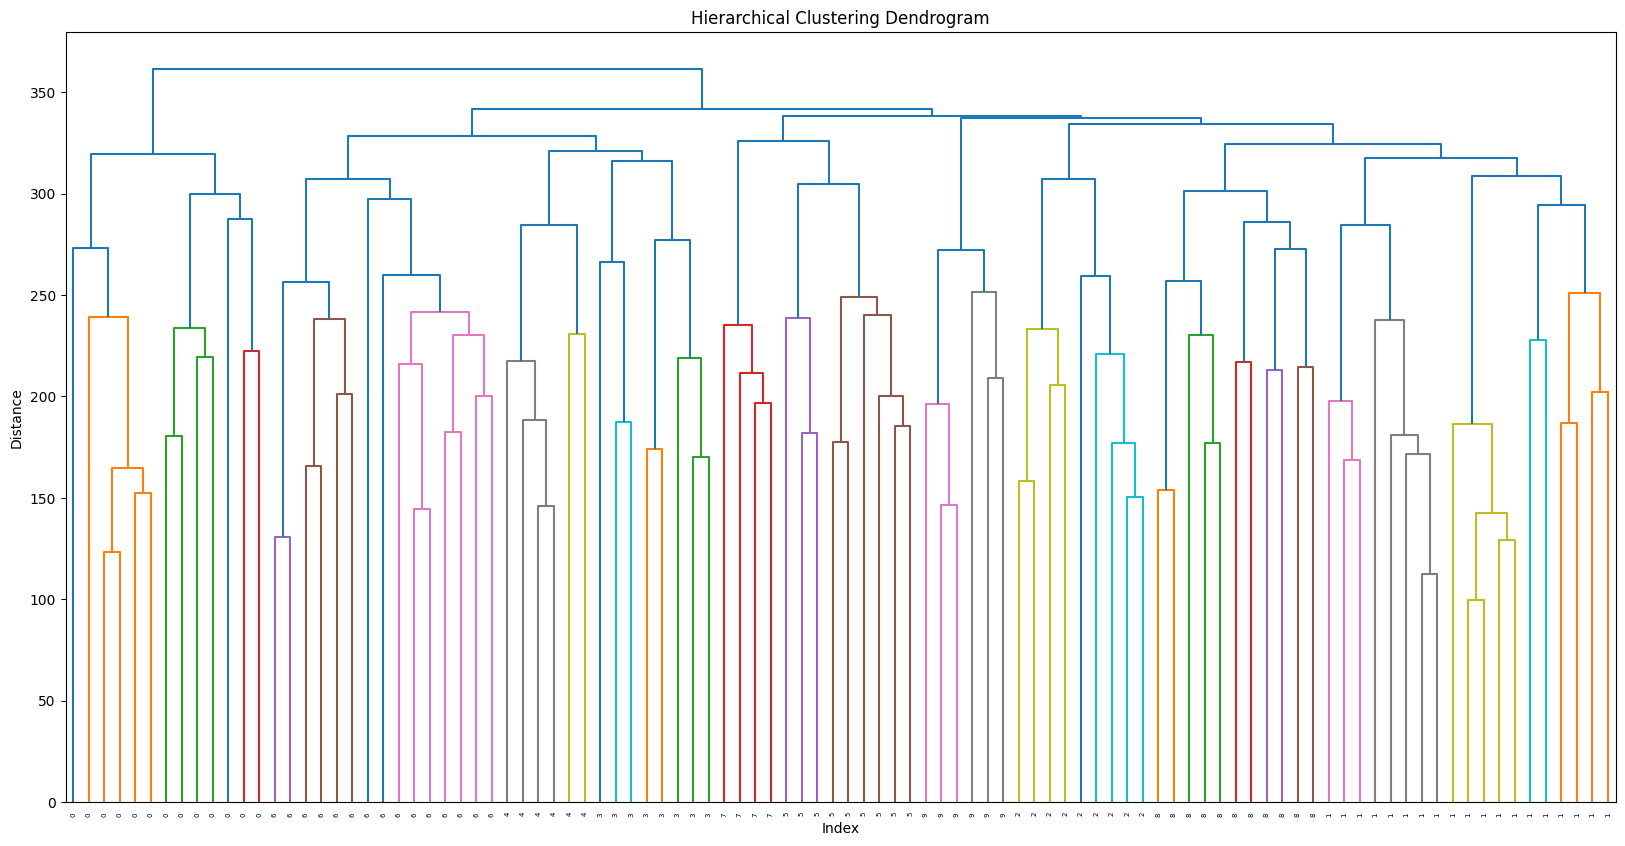

In [36]:
# plot agglomerative dendrogram

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel("Index")
    plt.ylabel("Distance")

plt.figure(figsize=(20, 10))
plot_dendrogram(agg, labels=agg.labels_)
plt.show()



In [46]:
print(agg.labels_)
print(np.unique(agg.labels_, return_counts=True))

[7 8 1 1 1 4 2 2 3 1 3 1 5 9 8 1 1 5 8 1 4 1 3 0 2 4 8 8 1 8 6 1 6 0 5 1 6
 5 5 1 1 3 5 5 8 8 1 0 3 0 6 8 0 7 2 1 0 7 9 0 0 3 2 6 6 6 6 6 0 0 2 0 1 6
 6 6 0 8 3 2 6 9 2 7 4 9 1 4 5 9 9 8 2 6 4 6 0 5 1 3]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([13, 19,  9,  8,  6,  9, 15,  4, 11,  6]))


In [44]:
# Let me build

clusters = []
curr_centroids = centroids.copy()

print(len(curr_centroids))

def compute_distance_matrix(centroids):
    distance_matrix = np.zeros((len(centroids), len(centroids)))
    for i in range(len(centroids)):
        for j in range(len(centroids)):
            distance_matrix[i][j] = np.linalg.norm(centroids[i] - centroids[j])
    return distance_matrix

def get_min_distance_indexes(distance_matrix):    
    # Temporarily set diagonal elements to infinity
    np.fill_diagonal(distance_matrix, np.inf)

    # Find the index of the minimum non-diagonal value
    min_index_flat = np.argmin(distance_matrix)
    min_index = np.unravel_index(min_index_flat, distance_matrix.shape)

    print("Index of the minimum non-diagonal value:", min_index)
    return min_index
    
res = compute_distance_matrix(curr_centroids)

id1, id2 = get_min_distance_indexes(res.copy())

i = 0

while len(clusters > 10):
    # compute distance matrix
    res = compute_distance_matrix(curr_centroids)
    # get min distance indexes
    id1, id2 = get_min_distance_indexes(res.copy())
    # merge the two clusters
    new_cluster = np.concatenate((clusters[id1], clusters[id2]))
    # remove the two clusters from the list
    del clusters[id1]
    del clusters[id2]
    # add the new cluster to the list
    clusters.append(new_cluster)
    # compute the new centroid
    new_centroid = np.mean(new_cluster, axis=0)
    # remove the two centroids from the list
    del curr_centroids[id1]
    del curr_centroids[id2]
    # add the new centroid to the list
    curr_centroids.append(new_centroid)

print(len(clusters))
print(len(curr_centroids))




100
Index of the minimum non-diagonal value: (11, 35)
[[ 0.         24.22536659 23.49476051 ... 22.80475998 24.0191803
  22.93259048]
 [24.22536659  0.         21.61994362 ... 21.84050369 23.18751526
  22.14816093]
 [23.49476051 21.61994362  0.         ... 22.28831291 13.26840019
  22.71621895]
 ...
 [22.80475998 21.84050369 22.28831291 ...  0.         22.06892014
  22.460392  ]
 [24.0191803  23.18751526 13.26840019 ... 22.06892014  0.
  23.29290009]
 [22.93259048 22.14816093 22.71621895 ... 22.460392   23.29290009
   0.        ]]


In [55]:
# compute birch clustering on the centroids for 10 clusters

res = cluster.Birch(n_clusters=10, branching_factor=10).fit_predict(np.array(centroids))

print(np.unique(res, return_counts=True))


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 9, 25, 10, 13,  9,  5,  8,  9,  6,  6]))


In [56]:
# perform affinity propagation on the centroids for 10 clusters

res = cluster.AffinityPropagation().fit_predict(np.array(centroids))

print(np.unique(res, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17]), array([10,  5,  5,  7,  5,  5,  2,  6,  4,  6,  3, 10,  4,  7,  6,  7,  3,
        5]))


In [62]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np


def get_even_clusters(X, cluster_size):
    n_clusters = int(np.ceil(len(X)/cluster_size))
    kmeans = KMeans(n_clusters)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    centers = centers.reshape(-1, 1, X.shape[-1]).repeat(cluster_size, 1).reshape(-1, X.shape[-1])
    distance_matrix = cdist(X, centers)
    clusters = linear_sum_assignment(distance_matrix)[1]//cluster_size
    return clusters, centers

clusters, centers = get_even_clusters(np.array(centroids), 10)

print(centers.shape)

print(centers)

print(np.unique(clusters, return_counts=True))

print(clusters)

(100, 344)
[[ 0.21547067 -0.22711223  0.10242379 ... -0.22655514 -0.78686845
   0.17687078]
 [ 0.21547067 -0.22711223  0.10242379 ... -0.22655514 -0.78686845
   0.17687078]
 [ 0.21547067 -0.22711223  0.10242379 ... -0.22655514 -0.78686845
   0.17687078]
 ...
 [ 0.83519626  0.04600457  0.18579414 ...  0.03878752  0.86576
  -0.73244935]
 [ 0.83519626  0.04600457  0.18579414 ...  0.03878752  0.86576
  -0.73244935]
 [ 0.83519626  0.04600457  0.18579414 ...  0.03878752  0.86576
  -0.73244935]]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]))
[6 7 2 1 9 4 0 0 7 6 6 2 8 5 0 2 6 3 0 5 4 2 4 8 0 4 7 1 6 7 1 3 2 3 1 2 2
 5 1 4 6 5 9 1 7 7 2 3 7 8 9 3 3 6 0 1 3 6 5 3 8 6 0 9 9 9 9 1 8 8 0 8 1 8
 9 5 8 9 7 0 9 5 3 6 4 5 4 4 2 5 5 4 0 7 4 8 3 1 2 7]


/Users/sebastiancavada/anaconda3/envs/ai701/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [63]:
reverse = {}

for i in range(len(clusters)):
    reverse[i] = clusters[i]

print (reverse)

{0: 6, 1: 7, 2: 2, 3: 1, 4: 9, 5: 4, 6: 0, 7: 0, 8: 7, 9: 6, 10: 6, 11: 2, 12: 8, 13: 5, 14: 0, 15: 2, 16: 6, 17: 3, 18: 0, 19: 5, 20: 4, 21: 2, 22: 4, 23: 8, 24: 0, 25: 4, 26: 7, 27: 1, 28: 6, 29: 7, 30: 1, 31: 3, 32: 2, 33: 3, 34: 1, 35: 2, 36: 2, 37: 5, 38: 1, 39: 4, 40: 6, 41: 5, 42: 9, 43: 1, 44: 7, 45: 7, 46: 2, 47: 3, 48: 7, 49: 8, 50: 9, 51: 3, 52: 3, 53: 6, 54: 0, 55: 1, 56: 3, 57: 6, 58: 5, 59: 3, 60: 8, 61: 6, 62: 0, 63: 9, 64: 9, 65: 9, 66: 9, 67: 1, 68: 8, 69: 8, 70: 0, 71: 8, 72: 1, 73: 8, 74: 9, 75: 5, 76: 8, 77: 9, 78: 7, 79: 0, 80: 9, 81: 5, 82: 3, 83: 6, 84: 4, 85: 5, 86: 4, 87: 4, 88: 2, 89: 5, 90: 5, 91: 4, 92: 0, 93: 7, 94: 4, 95: 8, 96: 3, 97: 1, 98: 2, 99: 7}


In [67]:
np.sum(c, axis=1)

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [68]:
false_negative = np.ma.array(a,mask=c)
sum_fn = np.sum(false_negative)
print(sum_fn/y.shape[0])

0.11337628040973112


[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
0.11337628040973112


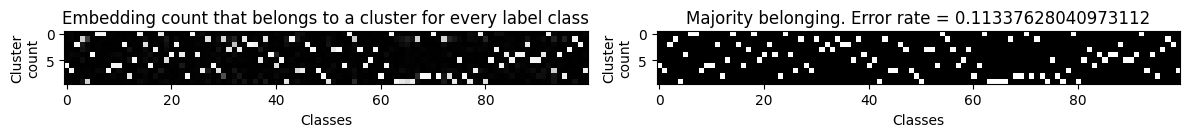

In [77]:
def plot_stuff(embeddings, y):
    # Your data and operations here
    a = np.zeros((10,100))

    for i, x in enumerate(embeddings):
        distances = np.linalg.norm(centroids - x, axis=1)
        first_index = np.argsort(distances)[0]    
        a[reverse[first_index]][y[i]] += 1
        
    ## majority voting for each class
    b = np.argmax(a, axis=0)

    c = np.zeros((10,100))
    for x in range(100):    
        c[b[x]][x] = 1

    print(np.sum(c, axis=1))

    false_negative = np.ma.array(a,mask=c)
    sum_fn = np.sum(false_negative)
    print(sum_fn/y.shape[0])

    # Start by creating a figure
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

    # First subplot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.xlabel("Classes")
    plt.ylabel("Cluster\ncount")
    plt.title("Embedding count that belongs to a cluster for every label class")
    plt.imshow(a, cmap='Greys_r')

    # Second subplot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.xlabel("Classes")
    plt.ylabel("Cluster\ncount")
    plt.title("Majority belonging. Error rate = " + str(sum_fn/y.shape[0]))
    plt.imshow(c, cmap='Greys_r')

    # Display the figure
    plt.tight_layout()  # This adjusts subplots to fit into the figure area.
    plt.show()

plot_stuff(embeddings, y)

In [78]:
with open('embeddings_all_l0.9_test.pkl', 'rb') as file:
    data = pickle.load(file)

x_test = data["outputs"].cpu().numpy()
y_test = data["labels"].cpu().numpy()
print(x_test.shape)
print(y_test.shape)

print(y_test[:30])

embeddings_test = np.array(x_test)
y_test = np.array(y_test)

(10000, 344)
(10000,)
[17 75 46  0 96 27 65 13 87 68  4 13  2 32 85 23 71 63 50 41 32 17 97 32
 95 26 61 62 51  1]


[13. 12.  9.  7.  8.  8.  9. 12. 16.  6.]
0.16963428297055058


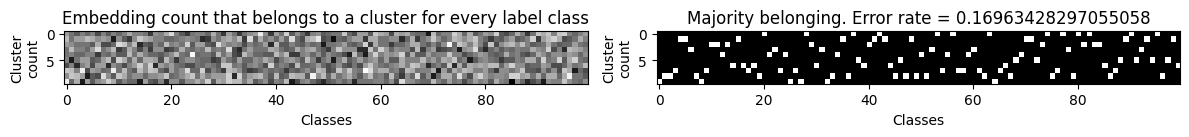

In [79]:
plot_stuff(embeddings_test)